In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import xsar
import xrft
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from leakage.velocity_leakage import * #S1DopplerLeakage, add_dca_to_leakage_class, slant2ground, low_pass_filter_2D_dataset, low_pass_filter_2D
from leakage.misc import round_to_hour, angular_difference, calculate_distance, power_spectrum_custom

func_rmse = lambda x, rounding=3:  np.round(np.sqrt(np.mean(x**2)).values*1, rounding)

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios.sort()
scenarios

['Aghulas_20190515',
 'Aghulas_20191110',
 'Aghulas_20200121',
 'Aghulas_20200203',
 'Aghulas_20200215',
 'Aghulas_20200227',
 'Aghulas_20200309',
 'Aghulas_20200310',
 'Aghulas_20200321',
 'Aghulas_20200322',
 'Aghulas_20200402',
 'Aghulas_20200403',
 'Aghulas_20200414',
 'Aghulas_20200415',
 'Aghulas_20200426',
 'Aghulas_20200427',
 'Azores_20201127',
 'Barbedos_20201110',
 'Brasilia_20200321',
 'Carrib_20231104',
 'Hawaii_20201106',
 'Iceland_20231107',
 'Morroco_20201103',
 'Scotland_20231109']

In [3]:
scenario = 'Aghulas_20200427' # 'Aghulas_20200427'# 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=50_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=300,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'sinc', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=35,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = 1,
    product_averaging_window='hann',
    # _interpolator = 'linear',

    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= False
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:512: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [4]:
test.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200427/02F0_278B_ABCD_EC97_res300.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200427h1700_lat-31_3_lon31_1.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

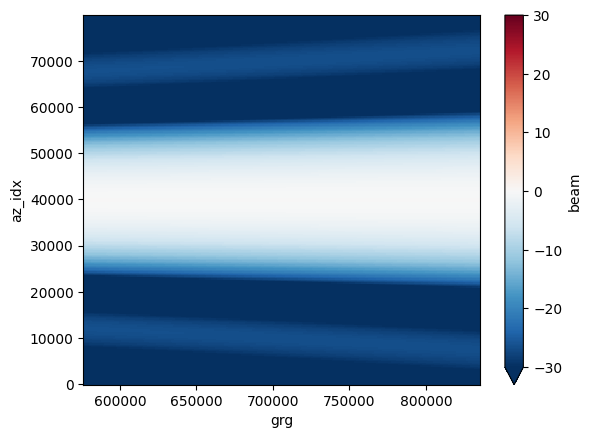

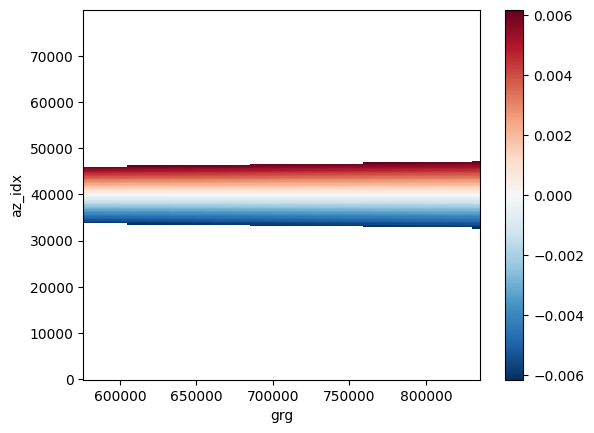

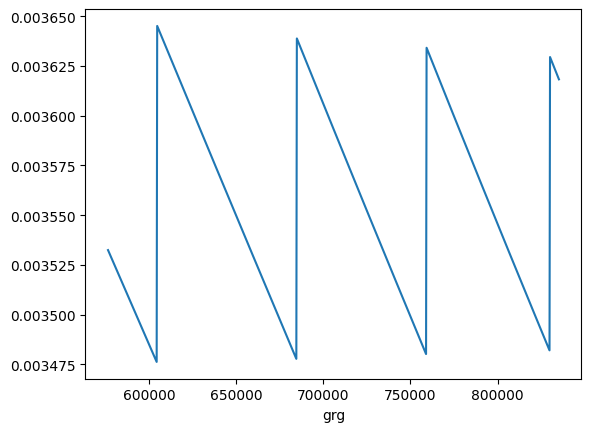

In [13]:
t = ((10*np.log10(test.data.beam)) - (10*np.log10(test.data.beam)).isel(az_idx = int(np.round(test.data.beam.sizes['az_idx'] / 2))) )
t.plot(vmin = -30)
plt.figure()
tt = xr.where(t<= -3, np.nan, test.data.az_angle_wrt_boresight)
tt.plot()
plt.figure()
tt.std(dim = 'az_idx').plot()

In [6]:
scenario = 'Aghulas_20200427' # 'Aghulas_20200427'# 'Azores_20201127'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test2 = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='../../data/leakage/era5_winds/',
    resolution_product=50_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=300,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern= 'phased_array', #'phased_array', sinc
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=35,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = 1,
    product_averaging_window='hann',
    # _interpolator = 'linear',

    # era5_smoothing_window=30,
    # denoise = True,
    # _pulsepair_noise = True
    # _speckle_noise= False
    )

/Users/opodriscoll/Documents/Scripts/DopSCA/src/leakage/velocity_leakage.py:512: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


In [7]:
test2.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20200427/02F0_278B_ABCD_EC97_res300.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: ../../data/leakage/era5_winds/era5_20200427h1700_lat-31_3_lon31_1.nc


/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/Users/opodriscoll/miniconda3/envs/dopsca/lib/python3.12/site

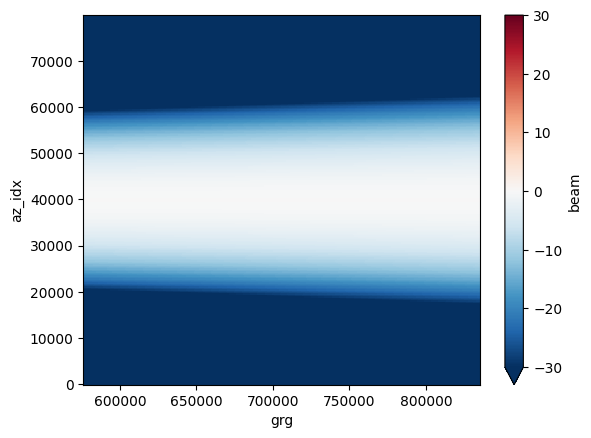

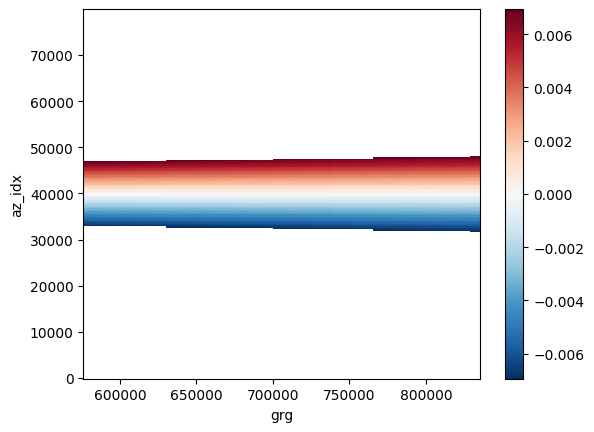

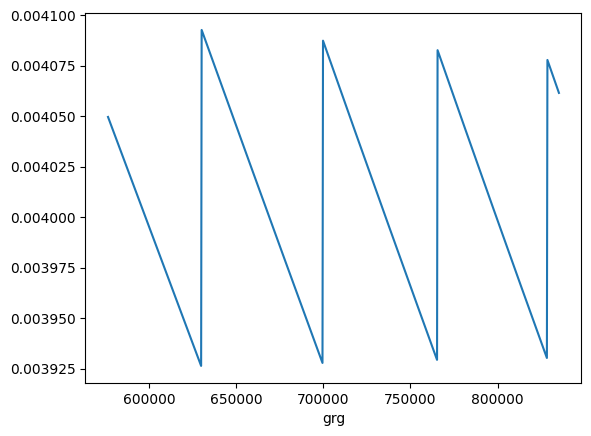

In [12]:
t = ((10*np.log10(test2.data.beam)) - (10*np.log10(test2.data.beam)).isel(az_idx = int(np.round(test2.data.beam.sizes['az_idx'] / 2))) )
t.plot(vmin = -30)
plt.figure()
tt = xr.where(t<= -3, np.nan, test2.data.az_angle_wrt_boresight)
tt.plot()
plt.figure()
tt.std(dim = 'az_idx').plot()